In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow

In [1]:
!pip uninstall -y protobuf
!pip install "protobuf<4"

Found existing installation: protobuf 6.33.0
Uninstalling protobuf-6.33.0:
  Successfully uninstalled protobuf-6.33.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; pyth

In [2]:
# Imports essentiels
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import math
import cv2


# TensorFlow et Keras
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

2026-01-01 22:18:39.864973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767305920.018016      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767305920.068689      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU'))} GPU(s)")

TensorFlow version: 2.18.0
GPU disponible: 1 GPU(s)


In [4]:
# Configuration GPU optimisée
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.optimizer.set_jit(True)
        print(f"✓ {len(gpus)} GPU(s) configuré(s)")
    except RuntimeError as e:
        print(f"Erreur: {e}")
else:
    print("⚠ Utilisation du CPU")

✓ 1 GPU(s) configuré(s)


In [5]:
from tensorflow.keras import mixed_precision

# Active la précision mixte
tf.config.optimizer.set_jit(True)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Compute dtype:', policy.compute_dtype)  # Doit afficher 'float16'
print('Variable dtype:', policy.variable_dtype) # Doit afficher 'float32'

Compute dtype: float16
Variable dtype: float32


In [ ]:
# --- Path configuration ---
PATH = "/kaggle/input/2-computer-vision-2025-b-sc-aidams-final-proj/" #Ajuster selon votre dossier personnel
train_dir = Path(PATH) / "train"
test_dir  = Path(PATH) / "test"

# --- Load files ---
train_files = sorted([str(p) for p in train_dir.iterdir() if p.is_file()])
test_files  = sorted([str(p) for p in test_dir.iterdir() if p.is_file()])
test_ids    = [Path(f).stem for f in test_files]

print(f"✓ {len(train_files)} training images")
print(f"✓ {len(test_files)} test images")

# --- Load labels ---
y_train_df = pd.read_csv(Path(PATH) / "train_labels.csv")
y_train_df["Id"] = y_train_df["Id"].astype(str)

# --- Create dictionary of labels with multiple formats ---
y_train_dict = {}
for _, row in y_train_df.iterrows():
    id_val = str(row["Id"])
    label = row["Label"]
    y_train_dict[id_val] = label
    try:
        # Add numeric variants
        id_int = int(id_val)
        y_train_dict[str(id_int)]      = label
        y_train_dict[f"{id_int:05d}"] = label
    except ValueError:
        pass  # ignore if conversion fails

# --- Encode labels ---
label_encoder = LabelEncoder()
label_encoder.fit(y_train_df["Label"])
num_classes = len(label_encoder.classes_)

print(f"\n✓ {num_classes} classes: {list(label_encoder.classes_)}")

✓ 9879 training images
✓ 9879 test images

✓ 7 classes: ['apple', 'facebook', 'google', 'messenger', 'mozilla', 'samsung', 'whatsapp']


In [7]:
# ============================================================
# GPU-OPTIMIZED DATASET PIPELINE (P100 SAFE)
# TensorFlow ONLY – no tensorflow_addons, no py_function
# Supports augment_factor = new augmented images
# ============================================================

import tensorflow as tf
from pathlib import Path
from sklearn.model_selection import train_test_split

# ============================================================
# GLOBAL CONFIG
# ============================================================

AUTOTUNE = tf.data.AUTOTUNE

tf.config.optimizer.set_jit(True)   # XLA ON (important for P100)

# ============================================================
# NORMALIZATION (ImageNet)
# ============================================================

@tf.function
def normalize_image(image):
    mean = tf.constant([0.485, 0.456, 0.406], tf.float32)
    std = tf.constant([0.229, 0.224, 0.225], tf.float32)
    return (image - mean) / std

# ============================================================
# GPU AUGMENTATIONS (FAST & SAFE)
# ============================================================

@tf.function
@tf.function
def training_augmentation(image):
    # 1. Flip Horizontal (Basique mais indispensable)
    image = tf.image.random_flip_left_right(image)

    # 2. Random Crop & Resize (Simule le zoom et la translation)
    # On prend une fenêtre entre 70% et 100% de l'image originale
    img_shape = tf.shape(image)
    crop_frac = tf.random.uniform([], 0.70, 1.0)
    target_h = tf.cast(tf.cast(img_shape[0], tf.float32) * crop_frac, tf.int32)
    target_w = tf.cast(tf.cast(img_shape[1], tf.float32) * crop_frac, tf.int32)
    
    image = tf.image.random_crop(image, [target_h, target_w, 3])
    image = tf.image.resize(image, [INPUT_SIZE, INPUT_SIZE])

    # 3. Color Jittering Avancé
    # On applique les transformations dans un ordre aléatoire pour plus de diversité
    if tf.random.uniform([]) < 0.8:
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        image = tf.image.random_saturation(image, 0.7, 1.3)
        image = tf.image.random_hue(image, 0.1)

    # 4. Ajout de Bruit Gaussien (Excellent pour la robustesse)
    if tf.random.uniform([]) < 0.3:
        stddev = tf.random.uniform([], 0.0, 0.03)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=stddev, dtype=tf.float32)
        image = image + noise

    # 5. "Smart Cutout" (Random Erasing avec pixels moyens)
    # Au lieu de mettre du noir, on remplace par la moyenne de l'image 
    # pour ne pas fausser la BatchNormalization.
    if tf.random.uniform([]) < 0.5:
        mask_size = tf.random.uniform([], 20, 56, tf.int32)
        y = tf.random.uniform([], 0, INPUT_SIZE - mask_size, tf.int32)
        x = tf.random.uniform([], 0, INPUT_SIZE - mask_size, tf.int32)
        
        # Calcul de la couleur moyenne de l'image pour le remplissage
        mean_color = tf.reduce_mean(image, axis=[0, 1])
        
        # Création du patch de remplacement
        patch = tf.ones([mask_size, mask_size, 3]) * mean_color
        
        # Padding pour positionner le patch à (x, y)
        mask = tf.pad(
            patch,
            [[y, INPUT_SIZE - y - mask_size],
             [x, INPUT_SIZE - x - mask_size],
             [0, 0]]
        )
        
        # Création d'un masque binaire pour la zone du cutout
        binary_mask = tf.cast(mask > 0, tf.float32)
        image = image * (1.0 - binary_mask) + mask

    # 6. Flou Aléatoire (Utile si les photos de test peuvent être floues)
    if tf.random.uniform([]) < 0.2:
        # Simulation d'un flou par redimensionnement
        blur_size = tf.random.uniform([], 0.6, 0.9)
        small_h = tf.cast(tf.cast(INPUT_SIZE, tf.float32) * blur_size, tf.int32)
        image = tf.image.resize(image, [small_h, small_h])
        image = tf.image.resize(image, [INPUT_SIZE, INPUT_SIZE])

    return tf.clip_by_value(image, 0.0, 1.0)

# ============================================================
# PREPROCESSING
# ============================================================

@tf.function
def preprocess_train(path, label, num_classes):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [INPUT_SIZE, INPUT_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    image = training_augmentation(image)
    image = normalize_image(image)

    label = tf.one_hot(label, num_classes)
    return image, label


@tf.function
def preprocess_val(path, label, num_classes):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [INPUT_SIZE, INPUT_SIZE])
    image = tf.cast(image, tf.float32) / 255.0

    image = normalize_image(image)
    label = tf.one_hot(label, num_classes)
    return image, label

# ============================================================
# MIXUP (OPTIONAL, GPU)
# ============================================================

@tf.function
def cutmix_batch(images, labels, alpha=1.0):
    """
    Implémentation du CutMix au niveau du batch.
    alpha: paramètre de la loi Beta (1.0 est standard pour CutMix)
    """
    batch_size = tf.shape(images)[0]
    img_h = tf.shape(images)[1]
    img_w = tf.shape(images)[2]

    # 1. Tirage de lambda (proportion de l'image A conservée)
    # Pour CutMix, on utilise souvent une distribution Beta(alpha, alpha)
    # Ici simplifié avec une distribution uniforme pour plus de stabilité
    lam = tf.random.uniform([], 0.0, 1.0)
    
    # 2. Définition du rectangle de découpe
    # Ratio du rectangle par rapport à l'image
    cut_rat = tf.math.sqrt(1.0 - lam)
    cut_w = tf.cast(tf.cast(img_w, tf.float32) * cut_rat, tf.int32)
    cut_h = tf.cast(tf.cast(img_h, tf.float32) * cut_rat, tf.int32)

    # Centre du rectangle (aléatoire)
    cx = tf.random.uniform([], 0, img_w, tf.int32)
    cy = tf.random.uniform([], 0, img_h, tf.int32)

    # Coordonnées des coins (clipping pour rester dans l'image)
    bbx1 = tf.clip_by_value(cx - cut_w // 2, 0, img_w)
    bby1 = tf.clip_by_value(cy - cut_h // 2, 0, img_h)
    bbx2 = tf.clip_by_value(cx + cut_w // 2, 0, img_w)
    bby2 = tf.clip_by_value(cy + cut_h // 2, 0, img_h)

    # 3. Préparation du masque binaire (1 à l'extérieur du rectangle, 0 à l'intérieur)
    # On crée une grille de coordonnées
    patch_w = bbx2 - bbx1
    patch_h = bby2 - bby1
    
    # Si le patch est vide (à cause du clipping), on ne fait rien
    if patch_w == 0 or patch_h == 0:
        return images, labels

    # Création du masque de remplacement
    mask = tf.ones((patch_h, patch_w, tf.shape(images)[3]))
    mask = tf.pad(mask, [
        [bby1, img_h - bby2],
        [bbx1, img_w - bbx2],
        [0, 0]
    ])
    
    # 4. Mélange des images
    indices = tf.random.shuffle(tf.range(batch_size))
    images_b = tf.gather(images, indices)
    
    # Image finale = Image_A avec le trou bouché par Image_B
    mixed_images = images * (1.0 - mask) + images_b * mask

    # 5. Ajustement des labels proportionnellement à la surface réelle insérée
    # Calcul de la surface réelle après clipping
    actual_lam = 1.0 - tf.cast((patch_w * patch_h) / (img_h * img_w), tf.float32)
    
    labels_b = tf.gather(labels, indices)
    mixed_labels = actual_lam * labels + (1.0 - actual_lam) * labels_b

    return mixed_images, mixed_labels

# ============================================================
# AUGMENT FACTOR (TRUE NEW IMAGES)
# ============================================================

def expand_with_augmentation(path, label, augment_factor):
    return tf.data.Dataset.from_tensor_slices(
        (tf.repeat(path, augment_factor),
         tf.repeat(label, augment_factor))
    )

# ============================================================
# DATASET CREATION
# ============================================================

def create_dataset(
    files,
    label_dict,
    label_encoder,
    num_classes,
    batch_size,
    augment_factor=1,
    training=True,
    use_cutmix=False
):
    paths, labels = [], []

    for f in files:
        img_id = Path(f).stem
        if img_id in label_dict:
            paths.append(str(f))
            labels.append(label_encoder.transform([label_dict[img_id]])[0])

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    # 1. Expansion du dataset (multiplication des chemins)
    if training and augment_factor > 1:
        ds = ds.flat_map(
            lambda p, l: expand_with_augmentation(p, l, augment_factor)
        )

    # 2. Mélange (augmenter la taille du buffer si le dataset est grand)
    if training:
        ds = ds.shuffle(len(paths) * augment_factor)

    # 3. Preprocessing (Chargement + Augmentation GPU)
    if training:
        preprocess_fn = lambda p, l: preprocess_train(p, l, num_classes)
    else:
        preprocess_fn = lambda p, l: preprocess_val(p, l, num_classes)

    ds = ds.map(preprocess_fn, num_parallel_calls=AUTOTUNE)
    
    # 4. Batching
    # drop_remainder=True est crucial pour le training sur GPU (formes fixes)
    ds = ds.batch(batch_size, drop_remainder=training)

    # 5. CUTMIX (après le batch)
    if training and use_cutmix: # Assurez-vous que le nom de la variable correspond
        ds = ds.map(
            lambda x, y: cutmix_batch(x, y, alpha=1.0),
            num_parallel_calls=AUTOTUNE)

    # ==========================================
    # L'AJOUT EST ICI : REPEAT
    # ==========================================
    if training:
        # Permet de boucler indéfiniment pour ne jamais manquer de données 
        # durant les 'steps_per_epoch' de model.fit()
        ds = ds.repeat()
    # ==========================================

    ds = ds.prefetch(AUTOTUNE)
    return ds

# ============================================================
# FULL SETUP FUNCTION
# ============================================================

def setup_datasets(
    all_files,
    label_dict,
    label_encoder,
    num_classes,
    batch_size=64,
    augment_factor=2,
    validation_split=0.2,
    use_cutmix=True
):
    train_files, val_files = train_test_split(
        all_files,
        test_size=validation_split,
        random_state=42,
        shuffle=True
    )

    print("=" * 60)
    print("GPU-OPTIMIZED DATASET PIPELINE")
    print("=" * 60)
    print(f"Train files      : {len(train_files)}")
    print(f"Validation files : {len(val_files)}")
    print(f"Batch size       : {batch_size}")
    print(f"Augment factor   : {augment_factor}")
    print(f"CutMix            : {'ON' if use_cutmix else 'OFF'}")
    print("=" * 60)

    train_ds = create_dataset(
        train_files,
        label_dict,
        label_encoder,
        num_classes,
        batch_size,
        augment_factor=augment_factor,
        training=True,
        use_cutmix=use_cutmix
    )

    val_ds = create_dataset(
        val_files,
        label_dict,
        label_encoder,
        num_classes,
        batch_size,
        augment_factor=1,
        training=False,
        use_cutmix=False
    )

    steps_per_epoch = (len(train_files) * augment_factor) // batch_size
    val_steps = (len(val_files) + batch_size - 1) // batch_size

    print(f"Steps / epoch    : {steps_per_epoch}")
    print(f"Validation steps : {val_steps}")
    print("=" * 60)

    return train_ds, val_ds, steps_per_epoch, val_steps

In [22]:
INPUT_SIZE = 224
BATCH_SIZE = 64

train_dataset, val_dataset, steps_per_epoch, validation_steps = setup_datasets(
    all_files=train_files,         # ou la liste complète de tes fichiers images
    label_dict=y_train_dict,       # dictionnaire {image_id: label}
    label_encoder=label_encoder,
    num_classes=7,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    augment_factor=3,              # facultatif, par défaut 2
    use_cutmix=False
)

GPU-OPTIMIZED DATASET PIPELINE
Train files      : 7903
Validation files : 1976
Batch size       : 64
Augment factor   : 3
CutMix            : OFF
Steps / epoch    : 370
Validation steps : 31


In [23]:
# --------------------------------------------------
# 1. Norm & LayerScale
# --------------------------------------------------
def Norm(use_gn=False, groups=8):
    if use_gn:
        return layers.GroupNormalization(groups=groups)
    return layers.BatchNormalization()

class LayerScale(layers.Layer):
    """LayerScale léger pour modèles profonds"""
    def __init__(self, init_value=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.init_value = init_value
    
    def build(self, input_shape):
        self.gamma = self.add_weight(
            name='gamma',
            shape=(input_shape[-1],),
            initializer=tf.keras.initializers.Constant(self.init_value),
            trainable=True
        )
    
    def call(self, x):
        return x * self.gamma

# --------------------------------------------------
# 2. Attention : SE + Ghost
# --------------------------------------------------
def se_block_light(x, ratio=8):
    filters = x.shape[-1]
    reduced = max(filters // ratio, 8)  # SE plus léger
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(reduced, activation="swish")(se)
    se = layers.Dense(filters, activation="hard_sigmoid")(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.Multiply()([x, se])

class GhostSpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))
        self.max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))
        self.concat = layers.Concatenate(axis=-1)
        self.conv = layers.Conv2D(
            1, self.kernel_size, padding="same",
            activation="hard_sigmoid", use_bias=False
        )

    def call(self, x):
        avg_p = self.avg_pool(x)
        max_p = self.max_pool(x)
        attn = self.conv(self.concat([avg_p, max_p]))
        return layers.Multiply()([x, attn])

# --------------------------------------------------
# 3. Stochastic Depth
# --------------------------------------------------
class StochasticDepth(layers.Layer):
    def __init__(self, survival_prob, **kwargs):
        super().__init__(**kwargs)
        self.survival_prob = survival_prob

    def call(self, x, training=None):
        if not training or self.survival_prob >= 1.0:
            return x
        batch_size = tf.shape(x)[0]
        shape = [batch_size] + [1] * (len(x.shape) - 1)
        random_tensor = self.survival_prob + tf.random.uniform(shape, dtype=x.dtype)
        binary_tensor = tf.floor(random_tensor)
        return (x / self.survival_prob) * binary_tensor

# --------------------------------------------------
# 4. HybridPooling simplifiée
# --------------------------------------------------
class HybridPoolingLight(layers.Layer):
    def __init__(self, p=3.0, k=3, **kwargs):
        super().__init__(**kwargs)
        self.p_init = p
        self.k = k

    def build(self, input_shape):
        self.channels = input_shape[-1]
        self.p = self.add_weight(
            name='p', 
            shape=(1,), 
            initializer=tf.keras.initializers.Constant(self.p_init),
            trainable=True,
            dtype=tf.float32
        )
        self.eca_conv = layers.Conv1D(1, self.k, padding='same', use_bias=False, dtype=tf.float32)
        super().build(input_shape)

    def call(self, x):
        orig_dtype = x.dtype

        # Convertir x en float32 pour le calcul GeM
        x = tf.cast(x, tf.float32)
        p = tf.cast(self.p, tf.float32)

        # GeM
        x_clipped = tf.clip_by_value(x, 1e-6, tf.float32.max)
        x_pow = tf.pow(x_clipped, p)
        gem = tf.pow(tf.reduce_mean(x_pow, axis=[1,2]), 1.0 / p)  # [batch, channels]

        # ECA Attention (tout en float32)
        y = tf.expand_dims(gem, axis=-1)     # [batch, channels, 1]
        y = self.eca_conv(y)                 # [batch, channels, 1] float32
        y = tf.nn.sigmoid(y)
        y = tf.squeeze(y, axis=-1)           # [batch, channels] float32

        # Multiplication en float32 puis reconversion au type original
        out = tf.cast(gem * y, orig_dtype)
        return out

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# --------------------------------------------------
# 5. Bloc Résiduel V2 Light
# --------------------------------------------------
def residual_block_light(x, filters, strides=1, expansion=None, use_se=True, 
                         use_spatial=False, survival_prob=0.8, use_gn=False):
    shortcut = x
    in_filters = x.shape[-1]
    exp = expansion if expansion else max(2, in_filters // 16)  # expansion basée sur in_filters
    expanded = filters * exp
    kernel_size = 3 if in_filters < 128 else 5

    # --- Conv / DWConv ---
    if in_filters < 64:
        x = layers.Conv2D(expanded, 3, strides=strides, padding="same", use_bias=False)(x)
        x = Norm(use_gn)(x)
        x = layers.Activation("swish")(x)
    else:
        x = layers.Conv2D(expanded, 1, use_bias=False)(x)
        x = Norm(use_gn)(x)
        x = layers.Activation("swish")(x)
        x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding="same", use_bias=False)(x)
        x = Norm(use_gn)(x)
        x = layers.Activation("swish")(x)

    # --- Attention ---
    if use_se: x = se_block_light(x)
    if use_spatial: x = GhostSpatialAttention()(x)

    # --- Projection ---
    x = layers.Conv2D(filters, 1, use_bias=False)(x)
    x = Norm(use_gn)(x)
    x = LayerScale()(x)

    # --- Shortcut ---
    if strides != 1 or in_filters != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, use_bias=False)(shortcut)
        shortcut = Norm(use_gn)(shortcut)

    x = StochasticDepth(survival_prob)(x)
    return layers.Activation("swish")(layers.Add()([x, shortcut]))

# --------------------------------------------------
# 6. Modèle Final Light
# --------------------------------------------------
def create_ultra_light_model(num_classes, input_size=224):
    inputs = layers.Input((input_size, input_size, 3))

    # Stem
    x = layers.Conv2D(24, 3, strides=2, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    # Stages (filters, strides, expansion, se, spatial, repeats)
    configs = [
        (32,  1, None, False, False, 2),
        (56,  2, None, True,  False, 2),
        (80,  2, None, True,  True,  2),
        (112, 2, None, True,  True,  3),
        (160, 1, None, True,  True,  2),
    ]

    total_blocks = sum(c[5] for c in configs)
    block_id = 0

    for f, s, e, se, sp, r in configs:
        for i in range(r):
            stride = s if i == 0 else 1
            prob = 1.0 - (0.2 * block_id / total_blocks)  # SD moins agressif
            x = residual_block_light(x, f, stride, e, se, sp, prob)
            block_id += 1

    # Head
    x = layers.Conv2D(512, 1, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    
    x = HybridPoolingLight()(x)
    x = layers.Dropout(0.1)(x)
    
    x = layers.Dense(128, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    
    outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x)
    
    return models.Model(inputs, outputs, name="Ultra_Light_V2")

# Instanciation
model = create_ultra_light_model(num_classes=7)
model.summary()

Model: "Ultra_Light_V2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_6 (Cast)       │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_93 (Conv2D)  │ (None, 112, 112,  │        648 │ cast_6[0][0]      │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         96 │ conv2d_93[0][0]   │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_86       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 112, 112,  │     13,824 │ activation_86[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_87       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 112, 112,  │      2,048 │ activation_87[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_scale_9       │ (None, 112, 112,  │         32 │ batch_normalizat… │
│ (LayerScale)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 112, 112,  │        768 │ activation_86[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stochastic_depth_9  │ (None, 112, 112,  │          0 │ layer_scale_9[0]… │
│ (StochasticDepth)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 112, 112,  │          0 │ stochastic_depth… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_88       │ (None, 112, 112,  │          0 │ add_27[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 112, 112,  │     18,432 │ activation_88[0]

 Total params: 3,369,319 (12.85 MB)

 Trainable params: 3,342,839 (12.75 MB)

 Non-trainable params: 26,480 (103.44 KB)

In [24]:
from tensorflow.keras.callbacks import (EarlyStopping, LearningRateScheduler, ModelCheckpoint)

# --- 1. Schedule Cosinus avec Warmup Long ---
def cosine_annealing_with_warmup(epoch, total_epochs=70, warmup_epochs=7):
    initial_lr = 1e-3
    min_lr = 5e-6  # Un peu plus bas pour la convergence fine
    
    if epoch < warmup_epochs:
        # Warmup linéaire
        return initial_lr * (epoch + 1) / warmup_epochs
    
    # Cosine Decay
    progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
    cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
    lr = (initial_lr - min_lr) * cosine_decay + min_lr
    return lr

# --- 2. Configuration de l'Optimiseur ---
# On augmente légèrement le weight_decay pour compenser la légèreté du modèle
optimizer = AdamW(
    learning_rate=3e-4,
    weight_decay=1e-3, # Plus robuste contre le bruit du CutMix
    beta_1=0.9,
    beta_2=0.999,
    use_ema=True,
    ema_momentum=0.99
)

# --- 3. Loss avec Label Smoothing ---
# 0.1 est le standard "SOTA", 0.05 est plus prudent. Restons sur 0.1 pour le CutMix.
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)

# --- 4. Callbacks ---
callbacks = [
    LearningRateScheduler(cosine_annealing_with_warmup, verbose=1),
    
    # Patience augmentée car le Cosine Decay peut avoir des plateaux
    EarlyStopping(
        monitor="val_accuracy",
        patience=15, 
        restore_best_weights=True,
        verbose=1
    ),
    
    ModelCheckpoint(
        "ultra_light_v2_best.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    )
]

# --- 5. Compilation ---
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[
        "accuracy",
        TopKCategoricalAccuracy(k=3, name="top_3_accuracy")
    ],
    jit_compile=True # Accélère l'exécution sur GPU
)

print("✓ Modèle compilé")

✓ Modèle compilé


In [25]:
EPOCHS = 70
STEPS_PER_EPOCH = steps_per_epoch
VALIDATION_STEPS = validation_steps

print(f"Lancement de l'entraînement : {EPOCHS} époques")
print(f"Steps par époque : {STEPS_PER_EPOCH}")

history = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=val_dataset,
    validation_steps=VALIDATION_STEPS,
    callbacks=callbacks,
    verbose=1)

# 4. Sauvegarde finale après restauration des meilleurs poids
model.save("ultra_light_v2_final.keras")
print("Entraînement terminé et modèle sauvegardé.")

Lancement de l'entraînement : 70 époques
Steps par époque : 370

Epoch 1: LearningRateScheduler setting learning rate to 0.00014285714285714287.
Epoch 1/70
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.2569 - loss: 1.8877 - top_3_accuracy: 0.6058
Epoch 1: val_accuracy improved from -inf to 0.30162, saving model to ultra_light_v2_best.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 185s 222ms/step - accuracy: 0.2570 - loss: 1.8874 - top_3_accuracy: 0.6060 - val_accuracy: 0.3016 - val_loss: 1.6978 - val_top_3_accuracy: 0.7075 - learning_rate: 1.4286e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00028571428571428574.
Epoch 2/70
370/370 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3845 - loss: 1.5938 - top_3_accuracy: 0.7695
Epoch 2: val_accuracy improved from 0.30162 to 0.57237, saving model to ultra_light_v2_best.keras
370/370 ━━━━━━━━━━━━━━━━━━━━ 66s 177ms/step - accuracy: 0.3846 - loss: 1.5935 - top_3_accuracy: 0.7696 - val_accuracy: 0.5724 - val_loss: 1.2175 - val_t

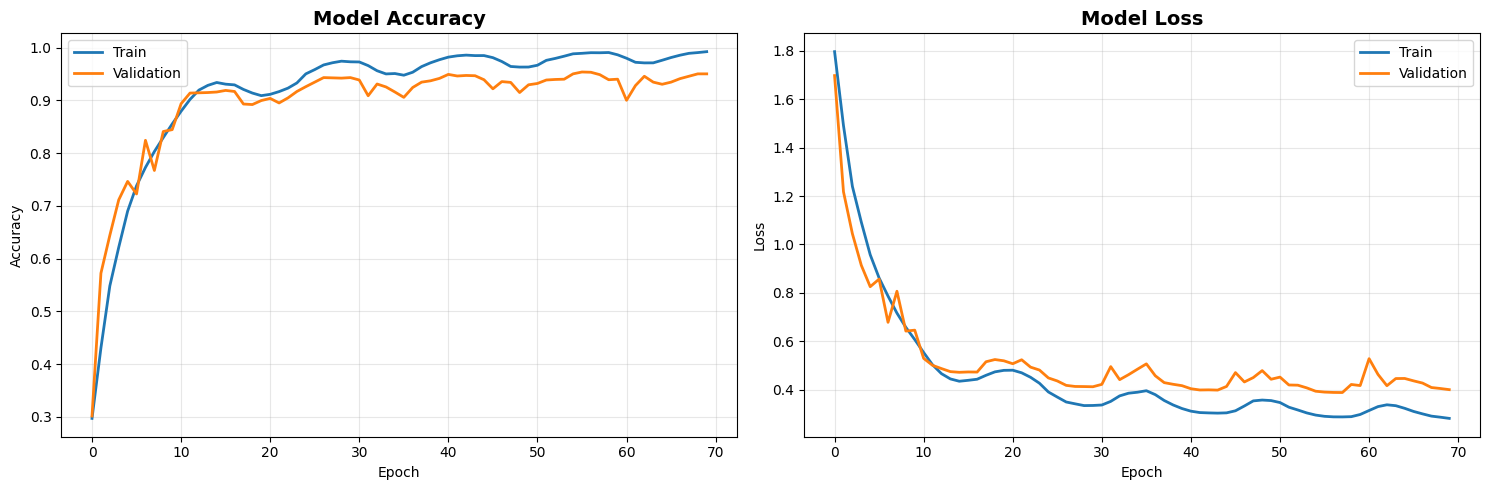


BEST VALIDATION ACCURACY: 0.9539 (95.39%)


In [26]:
# Assuming your final training history is called `history`
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Best metrics
best_val_acc = max(history.history['val_accuracy'])
print(f"\n{'='*50}")
print(f"BEST VALIDATION ACCURACY: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"{'='*50}")

In [30]:
# --- Load the best model ---
try:
    model = tf.keras.models.load_model(
        "best_model.keras")
    print("✓ Best model loaded")
except:
    print("⚠ Using the current model")

# ============================================================
# TTA PREDICTION PIPELINE (OPTIMIZED FOR P100)
# ============================================================

@tf.function
def tta_preprocess_image(path, input_size):
    """Charge et génère 4 variantes d'une image (Original, Flip, Bright, Zoom)"""
    # 1. Chargement et décodage
    img_bytes = tf.io.read_file(path)
    img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.image.resize(img, (input_size, input_size), method='bilinear')
    img = tf.cast(img, tf.float32) / 255.0

    # 2. Normalisation ImageNet (Standard pour les modèles pré-entraînés)
    mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
    std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
    img = (img - mean) / std

    # 3. Création des variantes
    # Originale
    img_orig = img
    # Flip Horizontal
    img_flip = tf.image.flip_left_right(img)
    # Luminosité légèrement augmentée
    img_bright = tf.image.adjust_brightness(img, 0.05)
    # Zoom central (Crop 90% puis resize)
    img_zoom = tf.image.central_crop(img, 0.9)
    img_zoom = tf.image.resize(img_zoom, (input_size, input_size))

    # Retourne un batch de 4 images [4, H, W, 3]
    return tf.stack([img_orig, img_flip, img_bright, img_zoom])

def predict_with_tta(test_files, model, label_encoder, input_size=224):
    """
    Exécute la prédiction avec Test Time Augmentation.
    Chaque image est prédite 4 fois et les résultats sont moyennés.
    """
    print(f"Starting TTA Prediction on {len(test_files)} files...")
    
    # Création du dataset (une image à la fois, chaque image devient un batch de 4)
    test_ds = tf.data.Dataset.from_tensor_slices(test_files)
    test_ds = test_ds.map(lambda p: tta_preprocess_image(p, input_size), 
                          num_parallel_calls=tf.data.AUTOTUNE)
    test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

    all_final_probs = []

    # Boucle de prédiction
    for tta_batch in test_ds:
        # tta_batch shape: [4, 224, 224, 3]
        # On prédit les 4 variantes d'un coup
        preds = model.predict_on_batch(tta_batch) # Result shape: [4, num_classes]
        
        # On fait la moyenne des probabilités (Softmax) des 4 variantes
        avg_probs = np.mean(preds, axis=0)
        all_final_probs.append(avg_probs)

    # Conversion des probabilités en étiquettes
    all_final_probs = np.array(all_final_probs)
    pred_indices = np.argmax(all_final_probs, axis=1)
    pred_labels = label_encoder.inverse_transform(pred_indices)

    return pred_labels.tolist()

# ============================================================
# EXECUTION
# ============================================================

# Assurez-vous que INPUT_SIZE est défini (ex: 224)
y_test_pred = predict_with_tta(
    test_files=test_files, 
    model=model, 
    label_encoder=label_encoder, 
    input_size=INPUT_SIZE
)

print("-" * 30)
print(f"✓ {len(y_test_pred)} TTA predictions generated")
print(f"First 5 results: {y_test_pred[:5]}")

⚠ Using the current model
TTA Prediction on 9879 images
------------------------------
✓ 9879 TTA predictions generated
First 5 results: ['google', 'messenger', 'samsung', 'whatsapp', 'samsung']


⚠ Using the current model
Starting TTA Prediction on 9879 files...
------------------------------
✓ 9879 TTA predictions generated
First 5 results: ['google', 'messenger', 'samsung', 'whatsapp', 'samsung']


In [32]:
# Créer le fichier de soumission
submission_df = pd.DataFrame({
    'Id': test_ids,
    'Label': y_test_pred
})

submission_df.to_csv("submission.csv", index=False)
print(f"\n✓ Soumission sauvegardée avec {len(submission_df)} prédictions")
print(f"\nDistribution des prédictions:")
print(submission_df['Label'].value_counts())


✓ Soumission sauvegardée avec 9879 prédictions

Distribution des prédictions:
Label
google       2930
facebook     1635
samsung      1526
whatsapp     1403
apple        1021
messenger     830
mozilla       534
Name: count, dtype: int64


In [29]:
from IPython.display import FileLink
import os

# Vérification que le fichier existe avant de créer le lien
if os.path.exists("submission.csv"):
    display(FileLink("submission.csv"))
else:
    print("Le fichier submission.csv n'a pas été trouvé dans /kaggle/working/")

/kaggle/working/submission.csv